In [47]:
import fastf1
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.pipeline import Pipeline
from datetime import datetime
import joblib 
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

# Enable cache to speed up the data loading process
fastf1.Cache.enable_cache('cache') # Akan membuat folder cache

# Set style untuk plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

Load data Brazilian GP (Interlagos) - kita bisa mulai dengan data tahun sebelumnya untuk memahami pola dan karakteristik sirkuit.

In [4]:
# Brazilian GP 2024 data
session = fastf1.get_session(2024, 'Brazil', 'R')
session.load() 


print(f"Session: {session.event['EventName']} - {session.name}")
print(f"Date: {session.date}")
print(f"Circuit: {session.event['Location']}")

core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16'

Session: São Paulo Grand Prix - Race
Date: 2024-11-03 15:30:00
Circuit: São Paulo


# EDA (Exploratory Data Analysis)

In [5]:
# Dapatkan informasi dasar tentang hasil race
results = session.results
print("Race Results Overview:")
display(results[['DriverNumber', 'Abbreviation', 'TeamName', 'Position', 'Points', 'Time', 'Status']].head(10))

Race Results Overview:


,DriverNumber,Abbreviation,TeamName,Position,Points,Time,Status
1,1,VER,Red Bull Racing,1.0,26.0,0 days 02:06:54.430000,Finished
31,31,OCO,Alpine,2.0,18.0,0 days 00:00:19.477000,Finished
10,10,GAS,Alpine,3.0,15.0,0 days 00:00:22.532000,Finished
63,63,RUS,Mercedes,4.0,12.0,0 days 00:00:23.265000,Finished
16,16,LEC,Ferrari,5.0,10.0,0 days 00:00:30.177000,Finished
4,4,NOR,McLaren,6.0,8.0,0 days 00:00:31.372000,Finished
22,22,TSU,RB,7.0,6.0,0 days 00:00:42.056000,Finished
81,81,PIA,McLaren,8.0,4.0,0 days 00:00:44.943000,Finished
30,30,LAW,RB,9.0,2.0,0 days 00:00:50.452000,Finished
44,44,HAM,Mercedes,10.0,1.0,0 days 00:00:50.753000,Finished


In [6]:
# Analisis lap times untuk memahami performa driver
laps = session.laps
print(f"Total laps recorded: {len(laps)}")
print(f"Drivers in session: {laps['Driver'].unique()}")

# Basic statistics lap times
lap_stats = laps.groupby('Driver')['LapTime'].agg(['count', 'mean', 'std', 'min', 'max'])
lap_stats = lap_stats.sort_values('mean')
print('\nLap Time Statistics by Driver:')
display(lap_stats.head(10))

Total laps recorded: 1135
Drivers in session: ['VER' 'GAS' 'PER' 'ALO' 'LEC' 'STR' 'TSU' 'ZHO' 'HUL' 'LAW' 'OCO' 'NOR'
 'COL' 'HAM' 'BEA' 'SAI' 'RUS' 'BOT' 'PIA']

Lap Time Statistics by Driver:


,count,mean,std,min,max
Driver,,,,,
VER,67,0 days 00:01:28.050611940,0 days 00:00:12.761295774,0 days 00:01:20.472000,0 days 00:02:22.964000
HUL,27,0 days 00:01:28.307925925,0 days 00:00:09.431618308,0 days 00:01:23.764000,0 days 00:02:07.542000
OCO,67,0 days 00:01:28.326164179,0 days 00:00:12.954261076,0 days 00:01:21.771000,0 days 00:02:23.552000
GAS,67,0 days 00:01:28.442597014,0 days 00:00:12.013281042,0 days 00:01:21.645000,0 days 00:02:20.928000
RUS,67,0 days 00:01:28.507522388,0 days 00:00:12.642938821,0 days 00:01:21.645000,0 days 00:02:19.051000
NOR,67,0 days 00:01:28.599283582,0 days 00:00:12.387727571,0 days 00:01:21.517000,0 days 00:02:17.692000
LEC,67,0 days 00:01:28.651791044,0 days 00:00:11.105269594,0 days 00:01:21.631000,0 days 00:02:14.283000
PIA,67,0 days 00:01:28.761955223,0 days 00:00:11.318567212,0 days 00:01:21.532000,0 days 00:02:12.899000
TSU,67,0 days 00:01:28.801492537,0 days 00:00:11.326328335,0 days 00:01:21.828000,0 days 00:02:09.387000


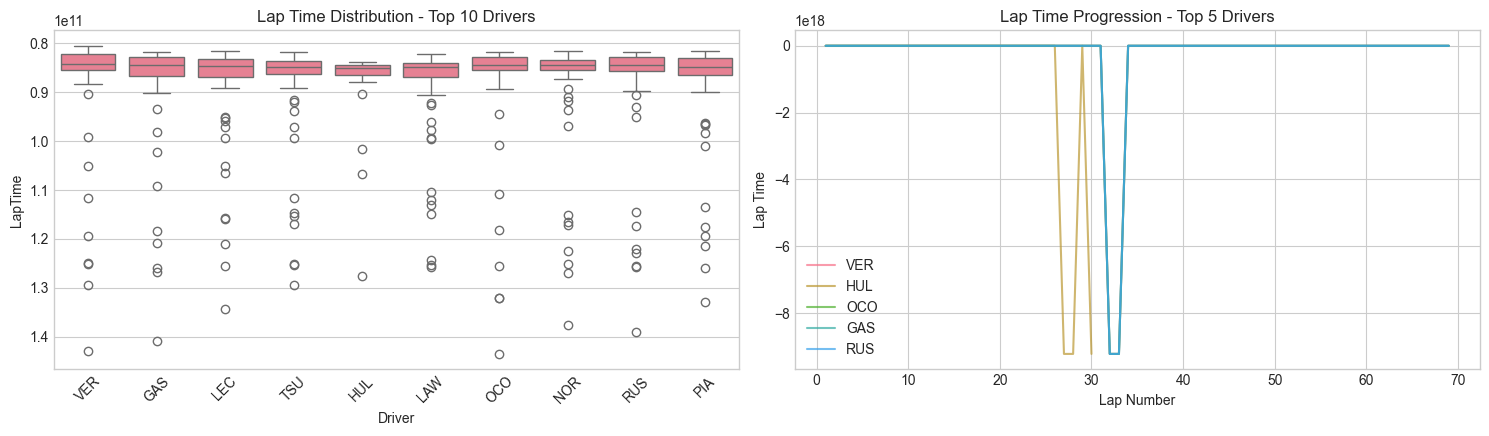

In [7]:
# Visualisasi distribusi lap times
plt.figure(figsize=(15, 8))

# Box plot lap times per driver (top 10 drivers)
top_drivers = lap_stats.head(10).index 
laps_top = laps[laps['Driver'].isin(top_drivers)]

plt.subplot(2, 2, 1)
sns.boxplot(data=laps_top, x='Driver', y='LapTime')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution - Top 10 Drivers')


# Lap time progression selama race
plt.subplot(2, 2, 2)
for driver in top_drivers[:5]: # Top 5 Drivers
    driver_laps = laps[laps['Driver'] == driver]
    plt.plot(driver_laps['LapNumber'], driver_laps['LapTime'], label=driver, alpha=0.7)
plt.xlabel('Lap Number')
plt.ylabel('Lap Time')
plt.title('Lap Time Progression - Top 5 Drivers')
plt.legend()

plt.tight_layout()
plt.show()

### 1. Analisis Strategi Ban (Tire Strategy)

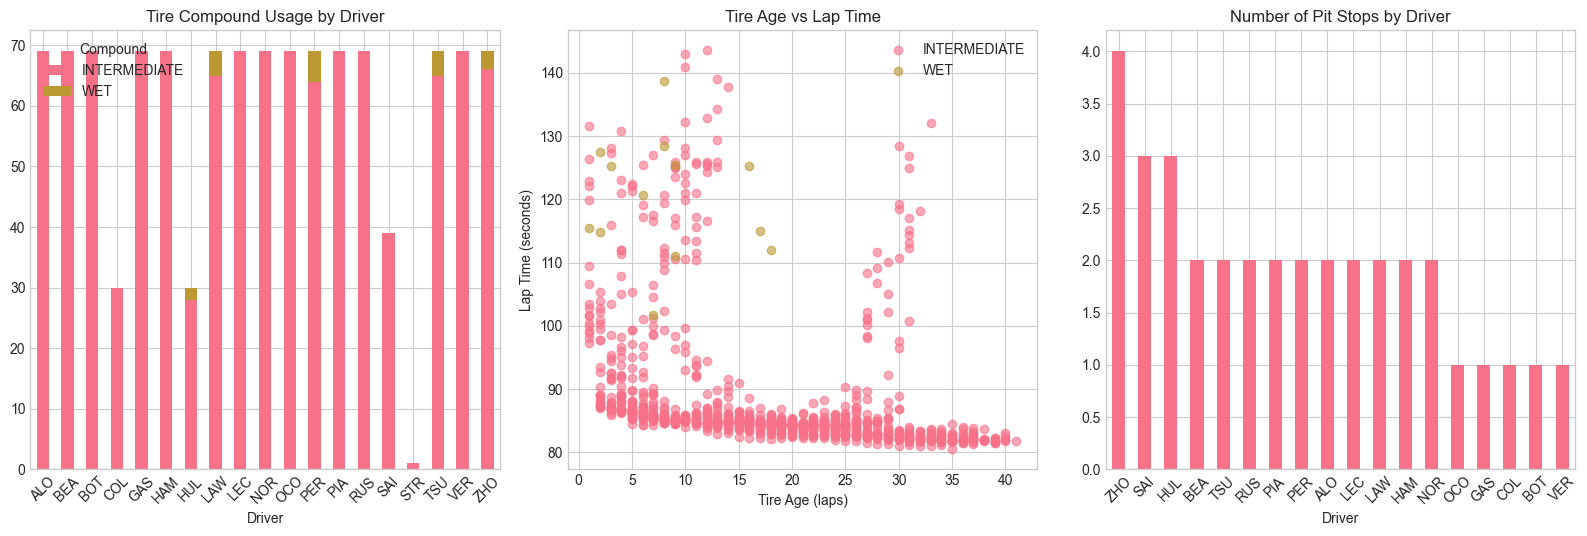

In [8]:
# Analisis strategi ban
plt.figure(figsize=(16, 10))

# Tire compound usage
plt.subplot(2, 3, 1)
tire_usage = laps.groupby(['Driver', 'Compound']).size().unstack(fill_value=0)
tire_usage.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Tire Compound Usage by Driver')
plt.xticks(rotation=45)
plt.legend(title='Compound')

# Tire age vs lap time
plt.subplot(2, 3, 2)
for compound in laps['Compound'].unique():
    if pd.notna(compound):
        compound_data = laps[laps['Compound'] == compound]
        plt.scatter(compound_data['TyreLife'], pd.to_timedelta(compound_data['LapTime']).dt.total_seconds(), 
                   label=compound, alpha=0.6)
plt.xlabel('Tire Age (laps)')
plt.ylabel('Lap Time (seconds)')
plt.title('Tire Age vs Lap Time')
plt.legend()

# Pit stop analysis
plt.subplot(2, 3, 3)
pit_stops = laps[laps['PitOutTime'].notna()]
pit_stop_counts = pit_stops.groupby('Driver').size().sort_values(ascending=False)
pit_stop_counts.plot(kind='bar')
plt.title('Number of Pit Stops by Driver')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### 2. Analisis Sektor dan Track Position

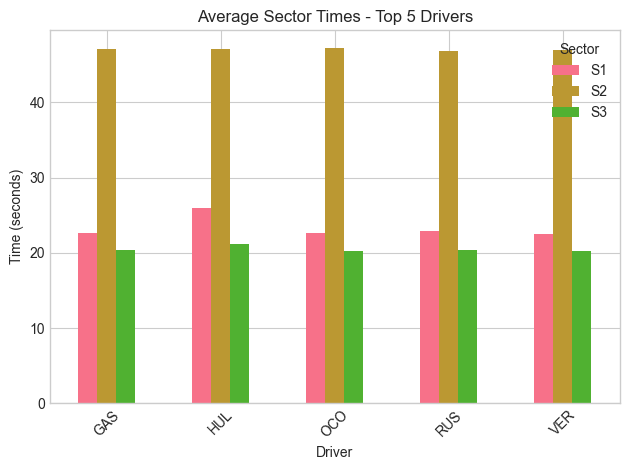

In [9]:
sectors = ['Sector1Time', 'Sector2Time', 'Sector3Time']
top_5_drivers = lap_stats.head(5).index


sector_data = []
for driver in top_5_drivers:
    driver_laps = laps[laps['Driver'] == driver]
    for i, sector in enumerate(sectors, 1):
        sector_times = driver_laps[sector].dropna()
        if len(sector_times) > 0:
            sector_data.append({
                'Driver': driver,
                'Sector': f"S{i}",
                "Time": sector_times.mean().total_seconds()
            })
            
sector_df = pd.DataFrame(sector_data)
if not sector_df.empty:
    sector_pivot = sector_df.pivot(index='Driver', columns='Sector', values='Time')
    sector_pivot.plot(kind='bar')
    plt.title('Average Sector Times - Top 5 Drivers')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


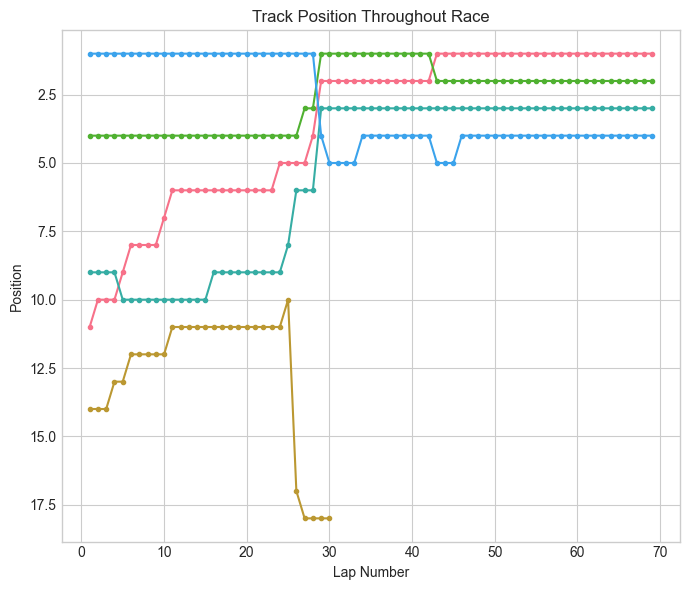

In [10]:
# Track position over time
plt.figure(figsize=(7, 6))
for driver in top_5_drivers:
    driver_laps = laps[laps['Driver'] == driver]
    plt.plot(driver_laps['LapNumber'], driver_laps['Position'],
             label=driver, marker='o', markersize=3)
plt.xlabel('Lap Number')
plt.ylabel('Position')
plt.title('Track Position Throughout Race')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

### 3. Analisis Cuaca dan Kondisi Track

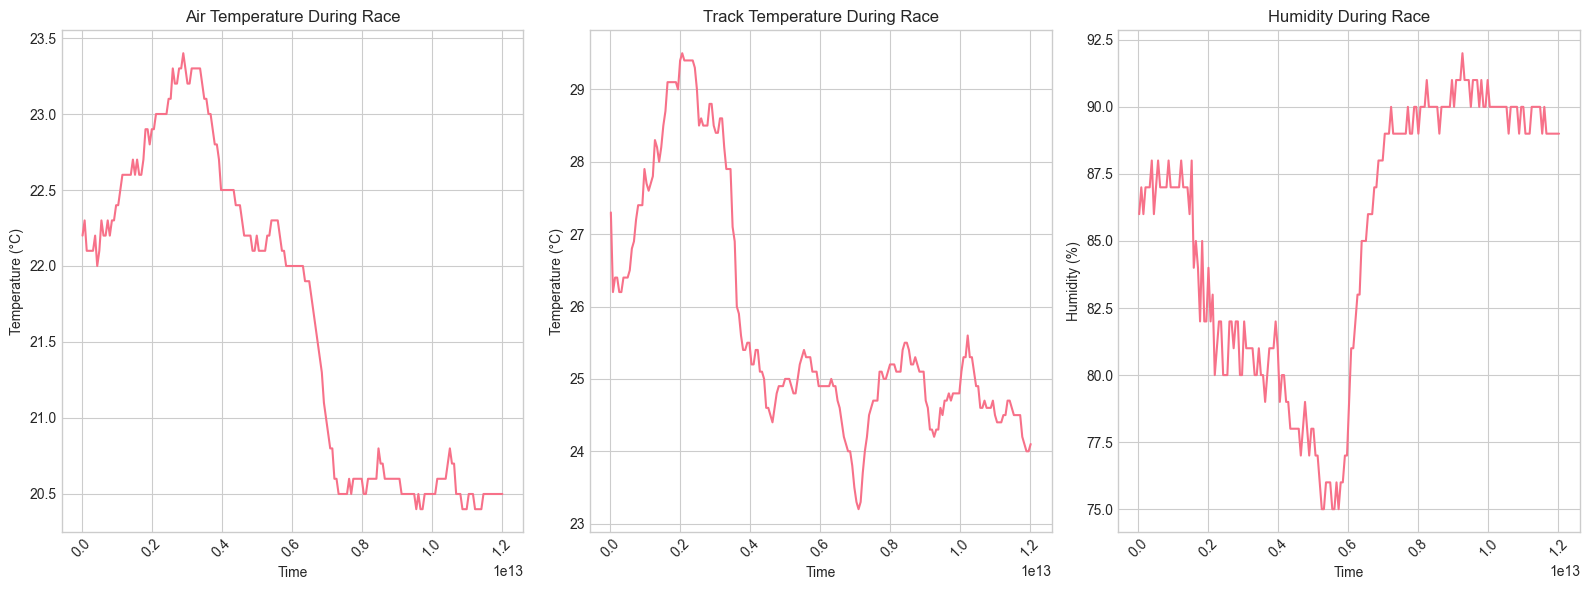

In [11]:
# Weather analysis
weather_data = session.weather_data
if not weather_data.empty:
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(weather_data['Time'], weather_data['AirTemp'])
    plt.title('Air Temperature During Race')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 2)
    plt.plot(weather_data['Time'], weather_data['TrackTemp'])
    plt.title('Track Temperature During Race')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 3)
    plt.plot(weather_data['Time'], weather_data['Humidity'])
    plt.title('Humidity During Race')
    plt.xlabel('Time')
    plt.ylabel('Humidity (%)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else: 
    print('Weather data not available for this session.')


### 4. Analisis Telemtry 

Faster lap by: VER
Lap time: 0 days 00:01:20.472000


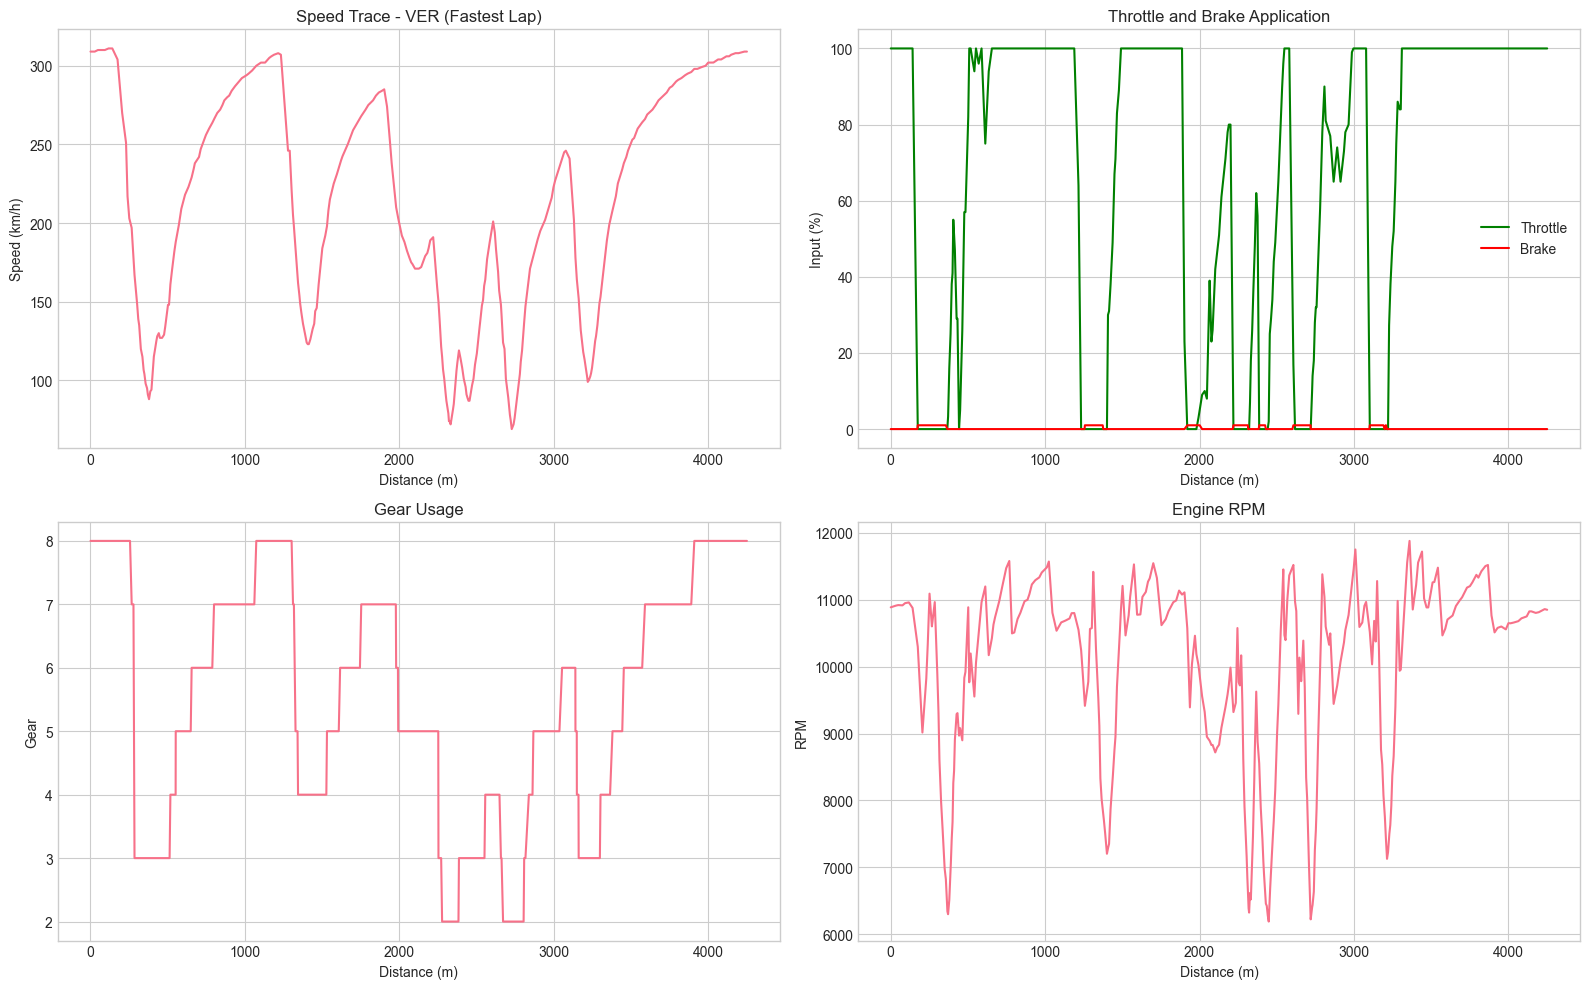

In [12]:
# Telemetry analysis untuk fastest lap
fastest_lap = laps.pick_fastest()
fastest_driver = fastest_lap['Driver']

print(f"Faster lap by: {fastest_driver}")
print(f"Lap time: {fastest_lap['LapTime']}")

# Get telemetry data
try:
    telemetry = fastest_lap.get_telemetry()
    
    plt.figure(figsize=(16, 10))
    
    # Speed trace
    plt.subplot(2, 2, 1)
    plt.plot(telemetry['Distance'], telemetry['Speed'])
    plt.title(f'Speed Trace - {fastest_driver} (Fastest Lap)')
    plt.xlabel('Distance (m)')
    plt.ylabel('Speed (km/h)')

    # Throttle and brake    
    plt.subplot(2, 2, 2)
    plt.plot(telemetry['Distance'], telemetry['Throttle'], label='Throttle', color='green')
    plt.plot(telemetry['Distance'], telemetry['Brake'], label='Brake', color='red')
    plt.title('Throttle and Brake Application')
    plt.xlabel('Distance (m)')
    plt.ylabel('Input (%)')
    plt.legend()
    
    # Gear usage
    plt.subplot(2, 2, 3)
    plt.plot(telemetry['Distance'], telemetry['nGear'])
    plt.title('Gear Usage')
    plt.xlabel('Distance (m)')
    plt.ylabel('Gear')
    
    # RPM
    plt.subplot(2, 2, 4)
    plt.plot(telemetry['Distance'], telemetry['RPM'])
    plt.title('Engine RPM')
    plt.xlabel('Distance (m)')
    plt.ylabel('RPM')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Telemetry data not available: {e}")
    

### 5. Analisis Perbandingan Tim

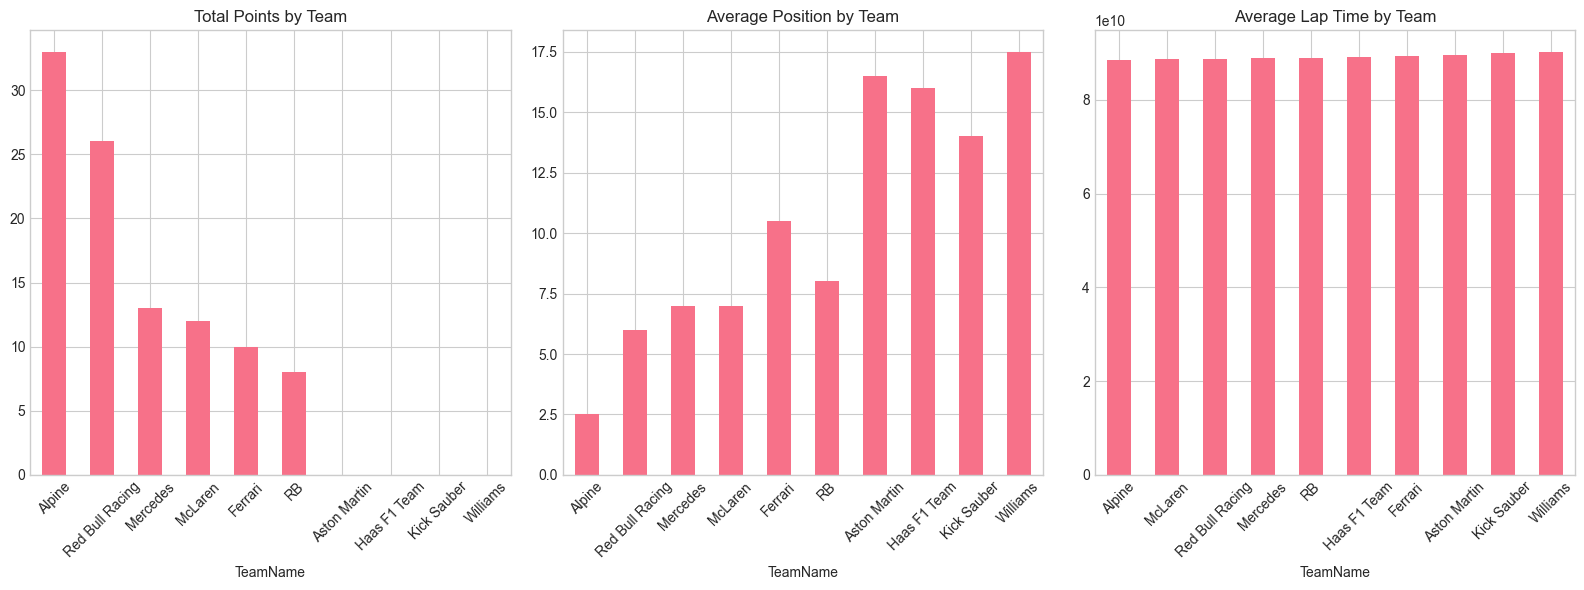

Team Performance Summary:


,Points,Position,Time
TeamName,,,
Alpine,33.0,2.5,0 days 00:00:21.004500
Red Bull Racing,26.0,6.0,0 days 01:03:52.980500
Mercedes,13.0,7.0,0 days 00:00:37.009000
McLaren,12.0,7.0,0 days 00:00:38.157500
Ferrari,10.0,10.5,0 days 00:00:30.177000
RB,8.0,8.0,0 days 00:00:46.254000
Aston Martin,0.0,16.5,0 days 00:01:18.049000
Haas F1 Team,0.0,16.0,0 days 00:00:57.085000
Kick Sauber,0.0,14.0,0 days 00:01:11.618500


In [13]:
# Team performance analysis
team_performance = results.groupby('TeamName').agg({
    'Points': 'sum',
    'Position': 'mean',
    'Time': 'mean'
}).sort_values('Points', ascending=False)

plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
team_performance['Points'].plot(kind='bar')
plt.title('Total Points by Team')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
team_performance['Position'].plot(kind='bar')
plt.title('Average Position by Team')
plt.xticks(rotation=45)

# Lap time comparison by team
plt.subplot(1, 3, 3)
team_lap_times = laps.merge(results[['DriverNumber', 'TeamName']],
                            left_on='DriverNumber', right_on='DriverNumber')
team_avg_times = team_lap_times.groupby('TeamName')['LapTime'].mean().sort_values()
team_avg_times.plot(kind='bar')
plt.title('Average Lap Time by Team')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print('Team Performance Summary:')
display(team_performance)

### 6. Korelasi dan Feature Engineering untuk Prediksi

In [14]:
# Aggregate features per driver
driver_features = laps.groupby('DriverNumber').agg({
    'LapTime': ['mean', 'std', 'min'],
    'Sector1Time': 'mean',
    'Sector2Time': 'mean',
    'Sector3Time': 'mean',
    'SpeedI1': 'mean',
    'SpeedI2': 'mean',
    'SpeedFL': 'mean',
    'SpeedST': 'mean',
    'Position': ['mean', 'std']
}).round(3)

# Flatten column names
driver_features.columns = ['_'.join(col).strip() for col in driver_features.columns]

# Merge dengan hasil akhir
final_features = driver_features.merge(
    results[['DriverNumber', 'Position', 'Points', 'TeamName']],
    left_index=True, right_on='DriverNumber'
)

print("Features for Prediction Model:")
display(final_features.head())

Features for Prediction Model:


,LapTime_mean,LapTime_std,LapTime_min,Sector1Time_mean,Sector2Time_mean,Sector3Time_mean,SpeedI1_mean,SpeedI2_mean,SpeedFL_mean,SpeedST_mean,Position_mean,Position_std,DriverNumber,Position,Points,TeamName
1,0 days 00:01:28.050611940,0 days 00:00:12.761295774,0 days 00:01:20.472000,0 days 00:00:22.549298507,0 days 00:00:46.992028985,0 days 00:00:20.228536231,286.424,209.652,293.074,249.647,3.565,2.963,1,1.0,26.0,Red Bull Racing
10,0 days 00:01:28.442597014,0 days 00:00:12.013281042,0 days 00:01:21.645000,0 days 00:00:22.577582089,0 days 00:00:47.161000,0 days 00:00:20.441000,282.167,207.565,291.706,244.532,5.449,3.080,10,3.0,15.0,Alpine
11,0 days 00:01:29.382447761,0 days 00:00:11.069105982,0 days 00:01:22.143000,0 days 00:00:22.977597014,0 days 00:00:47.065550724,0 days 00:00:20.394536231,275.104,201.725,298.149,240.621,13.333,2.758,11,11.0,0.0,Red Bull Racing
14,0 days 00:01:29.482089552,0 days 00:00:11.118590125,0 days 00:01:22.293000,0 days 00:00:23.183477611,0 days 00:00:46.781115942,0 days 00:00:20.857594202,277.226,209.348,293.716,234.800,11.348,2.672,14,14.0,0.0,Aston Martin
16,0 days 00:01:28.651791044,0 days 00:00:11.105269594,0 days 00:01:21.631000,0 days 00:00:22.894477611,0 days 00:00:46.809115942,0 days 00:00:20.440521739,283.020,214.551,294.851,249.045,5.580,1.519,16,5.0,10.0,Ferrari


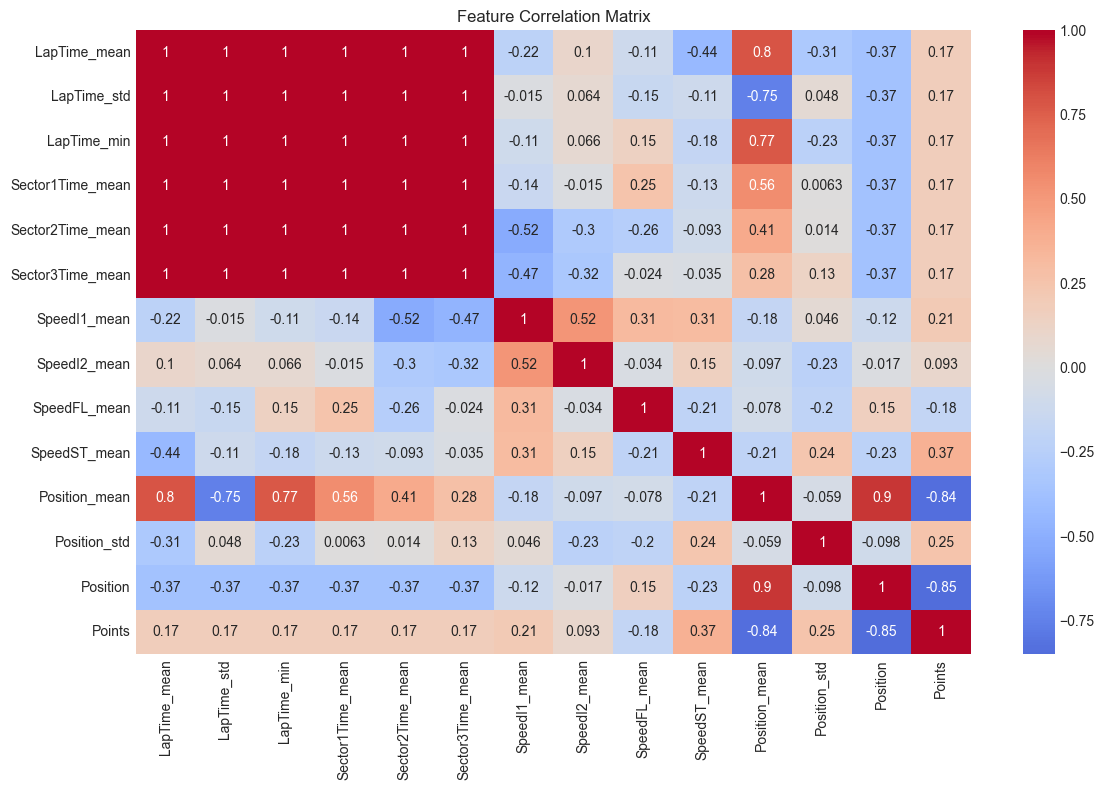

In [15]:
# Correlation matrix
plt.figure(figsize=(12, 8))
numeric_cols = final_features.select_dtypes(include=[np.number]).columns
correlation_matrix = final_features[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [16]:
# Advanced feature engineering berdasarkan correlation analysis
def create_advanced_features(laps, results, weather_data=None):
    """Create advanced features for F1 race prediction"""
    
    # 1. Pace-based features
    driver_pace_features = laps.groupby('DriverNumber').agg({
        'LapTime': ['mean', 'std', 'min', 'max'],
        'Sector1Time': ['mean', 'std'],
        'Sector2Time': ['mean', 'std'],
        'Sector3Time': ['mean', 'std'],
        'SpeedI1': ['mean', 'max'],
        'SpeedI2': ['mean', 'max'],
        'SpeedFL': ['mean', 'max'],
        'SpeedST': ['mean', 'max'],
        'Position': ['mean', 'std', 'min', 'max']
    })
    
    # Flatten column names
    driver_pace_features.columns = ['_'.join(col).strip() for col in driver_pace_features.columns]
    
    # 2. Consistency metrics
    consistency_features = laps.groupby('DriverNumber').apply(lambda x: pd.Series({
        'lap_time_cv': x['LapTime'].std() / x['LapTime'].mean() if x['LapTime'].mean() > pd.Timedelta(0) else 0,
        'position_changes': x['Position'].diff().abs().sum(),
        'fastest_lap_percentage': (x['LapTime'] == x['LapTime'].min()).sum() / len(x),
        'top_10_laps_percentage': (x['Position'] <= 10).sum() / len(x)
    }))
    
    # 3. Tire strategy features
    tire_features = laps.groupby('DriverNumber').agg({
        'TyreLife': ['mean', 'max'],
        'Compound': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'MEDIUM'
    })
    tire_features.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in tire_features.columns]
    
    # 4. Pit stop features
    pit_features = laps[laps['PitOutTime'].notna()].groupby('DriverNumber').agg({
        'PitOutTime': 'count'
    }).rename(columns={'PitOutTime': 'pit_stops'})
    
    
    # 5. Combine all features
    all_features = driver_pace_features.join([consistency_features, tire_features, pit_features], how='left')
    all_features = all_features.fillna(0)
    
    # 6. Add target variables from results
    targets = results[['DriverNumber', 'Position', 'Points', 'TeamName', 'Status']].set_index('DriverNumber')
    
    final_dataset = all_features.join(targets, how='inner')
    
    return final_dataset
    

In [17]:
# Create the advanced feature set
advanced_features = create_advanced_features(laps, results, weather_data)
print("Advanced Features Dataset Shape:", advanced_features.shape)
display(advanced_features.head())

Advanced Features Dataset Shape: (19, 34)


,LapTime_mean,LapTime_std,LapTime_min,LapTime_max,Sector1Time_mean,Sector1Time_std,Sector2Time_mean,Sector2Time_std,Sector3Time_mean,Sector3Time_std,...,fastest_lap_percentage,top_10_laps_percentage,TyreLife_mean,TyreLife_max,Compound_<lambda>,pit_stops,Position,Points,TeamName,Status
DriverNumber,,,,,,,,,,,,,,,,,,,,,
1,0 days 00:01:28.050611940,0 days 00:00:12.761295774,0 days 00:01:20.472000,0 days 00:02:22.964000,0 days 00:00:22.549298507,0 days 00:00:03.498146474,0 days 00:00:46.992028985,0 days 00:00:07.583882912,0 days 00:00:20.228536231,0 days 00:00:06.275308690,...,0.014493,0.985507,17.840580,37.0,INTERMEDIATE,1.0,1.0,26.0,Red Bull Racing,Finished
10,0 days 00:01:28.442597014,0 days 00:00:12.013281042,0 days 00:01:21.645000,0 days 00:02:20.928000,0 days 00:00:22.577582089,0 days 00:00:03.293907429,0 days 00:00:47.161000,0 days 00:00:07.032284374,0 days 00:00:20.441000,0 days 00:00:06.569641504,...,0.014493,1.000000,17.840580,37.0,INTERMEDIATE,1.0,3.0,15.0,Alpine,Finished
11,0 days 00:01:29.382447761,0 days 00:00:11.069105982,0 days 00:01:22.143000,0 days 00:02:08.473000,0 days 00:00:22.977597014,0 days 00:00:04.391072882,0 days 00:00:47.065550724,0 days 00:00:04.771981428,0 days 00:00:20.394536231,0 days 00:00:06.293099041,...,0.014493,0.173913,16.246377,37.0,INTERMEDIATE,2.0,11.0,0.0,Red Bull Racing,Finished
14,0 days 00:01:29.482089552,0 days 00:00:11.118590125,0 days 00:01:22.293000,0 days 00:02:07.072000,0 days 00:00:23.183477611,0 days 00:00:03.816590654,0 days 00:00:46.781115942,0 days 00:00:04.978798604,0 days 00:00:20.857594202,0 days 00:00:07.170706566,...,0.014493,0.608696,16.101449,37.0,INTERMEDIATE,2.0,14.0,0.0,Aston Martin,Finished
16,0 days 00:01:28.651791044,0 days 00:00:11.105269594,0 days 00:01:21.631000,0 days 00:02:14.283000,0 days 00:00:22.894477611,0 days 00:00:03.738955729,0 days 00:00:46.809115942,0 days 00:00:05.841452759,0 days 00:00:20.440521739,0 days 00:00:06.613824466,...,0.014493,0.971014,17.710145,40.0,INTERMEDIATE,2.0,5.0,10.0,Ferrari,Finished


In [18]:
def prepare_modeling_data(df):
    """Prepare data for machine learning models"""
    # Separate features and targets
    feature_cols = [col for col in df.columns if col not in ['Position', 'Points', 'TeamName', 'Status']]
    
    X = df[feature_cols].select_dtypes(include=[np.number])
    y_position = df['Position']
    y_points = df['Points']
    
    # Handle missing values
    X = X.fillna(X.median())
    
    # Feature scaling
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    
    # Feature selection using correlation and statistical tests
    # Remove highly correlated features (correlation > 0.95)
    corr_matrix = X_scaled.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    
    print(f"Removing {len(high_corr_features)} highly correlated features: {high_corr_features}")
    X_scaled = X_scaled.drop(columns=high_corr_features)
    
    # Select best features using statistical tests
    selector_position = SelectKBest(score_func=f_regression, k=min(10, X_scaled.shape[1]))
    selector_points = SelectKBest(score_func=f_regression, k=min(10, X_scaled.shape[1]))
    
    X_selected_position = selector_position.fit_transform(X_scaled, y_position)
    X_selected_points = selector_points.fit_transform(X_scaled, y_points)
    
    # Get selected feature names
    selected_features_position = X_scaled.columns[selector_position.get_support()].tolist()
    selected_features_points = X_scaled.columns[selector_points.get_support()].tolist()
    
    # Encode categorical variables
    le_team = LabelEncoder()
    team_encoded = le_team.fit_transform(df['TeamName'])
    
    le_status = LabelEncoder()
    status_encoded = le_status.fit_transform(df['Status'])
    
    return {
        'X_scaled': X_scaled,
        'X_selected_position': pd.DataFrame(X_selected_position, columns=selected_features_position, index=X.index),
        'X_selected_points': pd.DataFrame(X_selected_points, columns=selected_features_points, index=X.index),
        'y_position': y_position,
        'y_points': y_points,
        'team_encoded': team_encoded,
        'status_encoded': status_encoded,
        'scaler': scaler,
        'selector_position': selector_position,
        'selector_points': selector_points,
        'le_team': le_team,
        'le_status': le_status,
        'selected_features_position': selected_features_position,
        'selected_features_points': selected_features_points,
    }
    

In [19]:
# Apply the function
modeling_data = prepare_modeling_data(advanced_features)


print("Selected Features for Position Prediction:")
print(modeling_data['selected_features_position'])
print("\nSelected Features for Points Prediction:")
print(modeling_data['selected_features_points'])

Removing 9 highly correlated features: ['SpeedI1_max', 'SpeedI2_mean', 'SpeedI2_max', 'SpeedFL_mean', 'SpeedFL_max', 'SpeedST_mean', 'SpeedST_max', 'Position_min', 'TyreLife_max']
Selected Features for Position Prediction:
['SpeedI1_mean', 'Position_mean', 'Position_std', 'Position_max', 'lap_time_cv', 'position_changes', 'fastest_lap_percentage', 'top_10_laps_percentage', 'TyreLife_mean', 'pit_stops']

Selected Features for Points Prediction:
['SpeedI1_mean', 'Position_mean', 'Position_std', 'Position_max', 'lap_time_cv', 'position_changes', 'fastest_lap_percentage', 'top_10_laps_percentage', 'TyreLife_mean', 'pit_stops']


In [20]:
def analyze_feature_importance(modeling_data):
    """Analyze feature importance using different methods"""
    
    # Random Forest Feature Importance for Position
    rf_position = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_position.fit(modeling_data['X_selected_position'], modeling_data['y_position'])
    
    # Random Forest Feature Importance for Points
    rf_points = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_points.fit(modeling_data['X_selected_points'], modeling_data['y_points'])
    
    # Plot feature importance
    plt.figure(figsize=(16, 8))
    
    # Position prediction feature importance
    plt.subplot(1, 2, 1)
    feature_importance_pos = pd.DataFrame({
        'feature': modeling_data['selected_features_position'],
        'importance': rf_position.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.barh(feature_importance_pos['feature'], feature_importance_pos['importance'])
    plt.title('Feature Importance - Position Prediction')
    plt.xlabel('Importance')
    
    # Points prediction feature importance
    plt.subplot(1, 2, 2)
    feature_importance_pts = pd.DataFrame({
        'feature': modeling_data['selected_features_points'],
        'importance': rf_points.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.barh(feature_importance_pts['feature'], feature_importance_pts['importance'])
    plt.title('Feature Importance - Points Prediction')
    plt.xlabel('Importance')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'rf_position': rf_position,
        'rf_points': rf_points,
        'feature_importance_position': feature_importance_pos,
        'feature_importance_points': feature_importance_pts,
    }
    

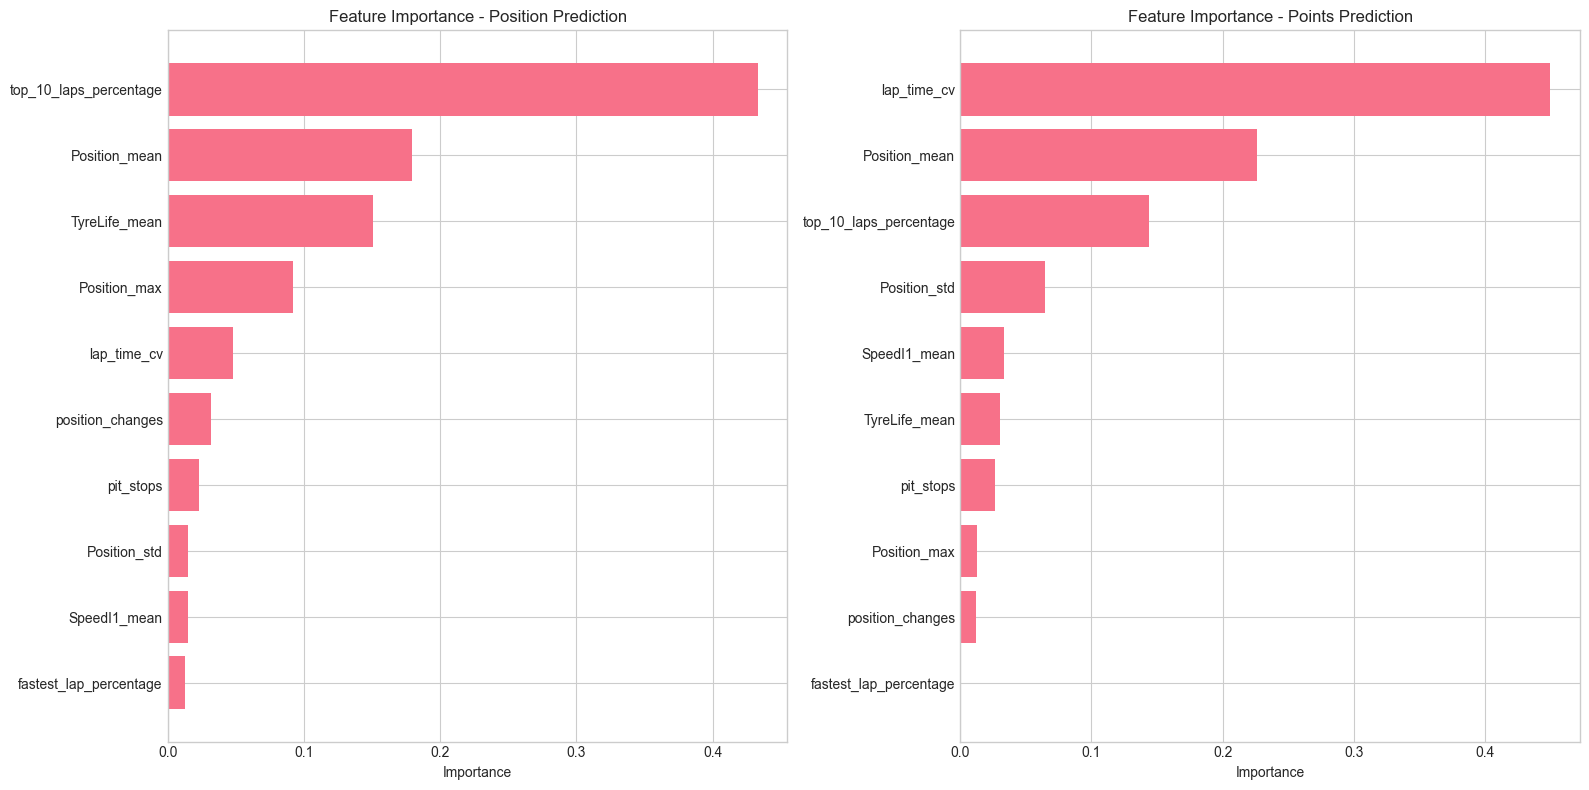

In [21]:
# Analyze feature importance
importance_analysis = analyze_feature_importance(modeling_data)

In [22]:
def create_domain_features_fixed(df):
    """
    Create F1-specific engineered features - FIXED VERSION
    """
    engineered_df = df.copy()
    
    # 1. First, identify and convert actual Timedelta columns
    timedelta_columns = []
    for col in df.columns:
        if 'timedelta' in str(df[col].dtype).lower():
            timedelta_columns.append(col)
            # Convert to seconds
            engineered_df[f'{col}_seconds'] = df[col].dt.total_seconds()
    
    print(f"Converted {len(timedelta_columns)} Timedelta columns to seconds: {timedelta_columns}")
    
    # 2. Work only with numeric columns for calculations
    numeric_cols = engineered_df.select_dtypes(include=[np.number]).columns
    
    # 3. Create engineered features using numeric data only
    
    # Pace differential (if we have lap time in seconds)
    laptime_sec_cols = [col for col in numeric_cols if 'LapTime_mean' in col and 'seconds' in col]
    if laptime_sec_cols:
        laptime_col = laptime_sec_cols[0]
        session_avg = engineered_df[laptime_col].mean()
        engineered_df['pace_differential'] = (engineered_df[laptime_col] - session_avg) / session_avg
    
    # Consistency score
    laptime_std_cols = [col for col in numeric_cols if 'LapTime_std' in col and 'seconds' in col]
    laptime_mean_cols = [col for col in numeric_cols if 'LapTime_mean' in col and 'seconds' in col]
    
    if laptime_std_cols and laptime_mean_cols:
        std_col = laptime_std_cols[0]
        mean_col = laptime_mean_cols[0]
        # Avoid division by zero
        mean_safe = engineered_df[mean_col].replace(0, engineered_df[mean_col].mean())
        engineered_df['consistency_score'] = engineered_df[std_col] / mean_safe
    
    # Position volatility
    if 'Position_std' in numeric_cols and 'Position_mean' in numeric_cols:
        mean_safe = engineered_df['Position_mean'].replace(0, 1)
        engineered_df['position_volatility'] = engineered_df['Position_std'] / mean_safe
    
    # Speed advantages
    speed_cols = [col for col in numeric_cols if 'Speed' in col and 'mean' in col]
    for speed_col in speed_cols:
        if speed_col in engineered_df.columns:
            session_avg_speed = engineered_df[speed_col].mean()
            if session_avg_speed != 0:
                engineered_df[f'{speed_col}_advantage'] = (engineered_df[speed_col] - session_avg_speed) / session_avg_speed
    
    # Pace vs fastest
    laptime_min_cols = [col for col in numeric_cols if 'LapTime_min' in col and 'seconds' in col]
    if laptime_min_cols and laptime_mean_cols:
        min_col = laptime_min_cols[0]
        mean_col = laptime_mean_cols[0]
        fastest_time = engineered_df[min_col].min()
        if fastest_time > 0:
            engineered_df['pace_vs_fastest'] = (engineered_df[mean_col] - fastest_time) / fastest_time
    
    # Tire efficiency
    if 'TyreLife_mean' in numeric_cols and laptime_mean_cols:
        tire_col = 'TyreLife_mean'
        laptime_col = laptime_mean_cols[0]
        tire_safe = engineered_df[tire_col].replace(0, 1)
        engineered_df['tire_efficiency'] = engineered_df[laptime_col] / tire_safe
    
    return engineered_df

In [23]:
try:
    engineered_features = create_domain_features_fixed(advanced_features)
    print(f"\nSuccess! Engineered Features Shape: {engineered_features.shape}")
    print("\nNew Engineered Features:")
    new_features = [col for col in engineered_features.columns if col not in advanced_features.columns]
    for feature in new_features:
        print(f"  - {feature}")
        
except Exception as e:
    print(f"Error occurred: {e}")
    print("Let's check the data structure...")

Converted 0 Timedelta columns to seconds: []

Success! Engineered Features Shape: (19, 39)

New Engineered Features:
  - position_volatility
  - SpeedI1_mean_advantage
  - SpeedI2_mean_advantage
  - SpeedFL_mean_advantage
  - SpeedST_mean_advantage


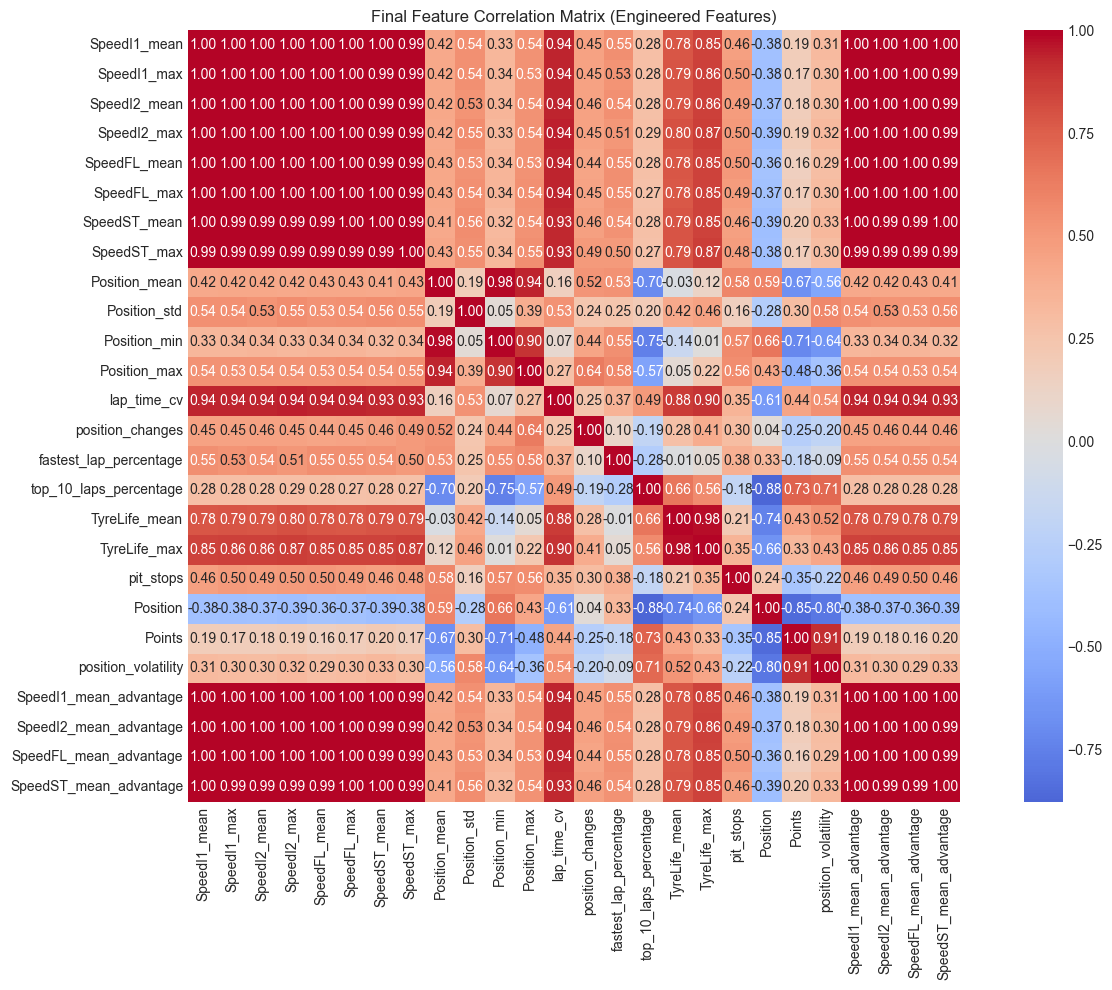

In [24]:
plt.figure(figsize=(14, 10))

key_features = [
    'LapTime_mean', 'Position_mean', 'Points',
    'pace_differential', 'consistency_score', 'position_volatility',
    'pace_vs_fastest'
] + [col for col in engineered_features.columns if 'advantage' in col]


# Filter features that exist in the dataframe
existing_features = [f for f in key_features if f in engineered_features.columns]
final_corr = engineered_features.select_dtypes(include=[np.number]).corr()

sns.heatmap(final_corr, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Final Feature Correlation Matrix (Engineered Features)')
plt.tight_layout()
plt.show()


# Modeling

In [25]:
def create_preprocessing_pipeline():
    """Create preprocessing pipeline for F1 data"""
    # Preprocessing steps
    preprocessor = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_regression, k=15))
    ])
    return preprocessor


# prepare clean data
def prepare_pipeline_data(engineered_features):
    """Prepare data specifically for sklearn pipeline"""
    df_clean = engineered_features.copy()
    
    # Convert timedelta columns to seconds
    for col in df_clean.columns:
        if 'timedelta' in str(df_clean[col].dtype).lower():
            df_clean[f'{col}_seconds'] = df_clean[col].dt.total_seconds()
            df_clean = df_clean.drop(columns=[col])
            
    # Keep only numeric columns
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    df_numeric = df_clean[numeric_cols]
    
    # Handle missing values and infinities
    df_numeric = df_numeric.fillna(df_numeric.median())
    df_numeric = df_numeric.replace([np.inf, -np.inf], np.nan)
    df_numeric = df_numeric.fillna(df_numeric.median())
    
    return df_numeric


In [26]:
# Prepare data
pipeline_df = prepare_pipeline_data(engineered_features)
print(f"Pipeline dataset shape: {pipeline_df.shape}")

# Separate features and targets
X = pipeline_df.drop(columns=['Position', 'Points'])
y_position = pipeline_df['Position']
y_points = pipeline_df['Points']

print(f"Features: {X.columns.tolist()}")


Pipeline dataset shape: (19, 26)
Features: ['SpeedI1_mean', 'SpeedI1_max', 'SpeedI2_mean', 'SpeedI2_max', 'SpeedFL_mean', 'SpeedFL_max', 'SpeedST_mean', 'SpeedST_max', 'Position_mean', 'Position_std', 'Position_min', 'Position_max', 'lap_time_cv', 'position_changes', 'fastest_lap_percentage', 'top_10_laps_percentage', 'TyreLife_mean', 'TyreLife_max', 'pit_stops', 'position_volatility', 'SpeedI1_mean_advantage', 'SpeedI2_mean_advantage', 'SpeedFL_mean_advantage', 'SpeedST_mean_advantage']


In [27]:
def create_model_pipeline():
    """Create different model pipelines for comparison"""
    
    # base preprocessing
    base_preprocessor = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_regression, k=12))
    ])
    
    # Advanced preprocessing with polynomial features
    poly_preprocessor = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('feature_selection', SelectKBest(score_func=f_regression, k=15))
    ])
    
    # Model pipelines
    pipelines = {
        'Random Forest': Pipeline([
            ('preprocessor', base_preprocessor),
            ('regressor', RandomForestRegressor(random_state=42))
        ]),
        
        'Gradient Boosting': Pipeline([
            ('preprocessor', base_preprocessor),
            ('regressor', GradientBoostingRegressor(random_state=42))
        ]),
        
        'Extra Trees': Pipeline([
            ('preprocessor', base_preprocessor),
            ('regressor', ExtraTreesRegressor(random_state=42))
        ]),
        
        'Ridge Regression': Pipeline([
            ('preprocessor', base_preprocessor),
            ('regressor', Ridge())
        ]),
        
        'Lasso Regression': Pipeline([
            ('preprocessor', base_preprocessor),
            ('regressor', Lasso())
        ]),
        
        'ElasticNet': Pipeline([
            ('preprocessor', base_preprocessor),
            ('regressor', ElasticNet())
        ]),
        
        'SVR': Pipeline([
            ('preprocessor', Pipeline([
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(score_func=f_regression, k=10))
            ])),
            ('regressor', SVR())
        ]),
        
        'Ridge Poly': Pipeline([
            ('preprocessor', poly_preprocessor),
            ('regressor', Ridge())
        ])
    }
    
    return pipelines



In [38]:
def get_param_grids():
    """Define parameter grids for hyperparameter tuning"""
    param_grids = {
        'Random Forest': {
            'preprocessor__feature_selection__k': [8, 12, 15],
            'regressor__n_estimators': [50, 100, 200],
            'regressor__max_depth': [5, 10, None],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__min_samples_leaf': [1, 2, 4]
        },
        
        'Gradient Boosting': {
            'preprocessor__feature_selection__k': [8, 12, 15],
            'regressor__n_estimators': [50, 100, 150],
            'regressor__learning_rate': [0.01, 0.1, 0.2],
            'regressor__max_depth': [3, 5, 7],
            'regressor__subsample': [0.8, 0.9, 1.0]
        },
        
        'Extra Trees': {
            'preprocessor__feature_selection__k': [8, 12, 15],
            'regressor__n_estimators': [50, 100, 200],
            'regressor__max_depth': [5, 10, None],
            'regressor__min_samples_split': [2, 5, 10]
        },
        
        'Ridge Regression': {
            'preprocessor__feature_selection__k': [8, 12, 15, 20],
            'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
        },
        
        'Lasso Regression': {
            'preprocessor__feature_selection__k': [8, 12, 15, 20],
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
        },
        
        'ElasticNet': {
            'preprocessor__feature_selection__k': [8, 12, 15],
            'regressor__alpha': [0.1, 1.0, 10.0],
            'regressor__l1_ratio': [0.1, 0.5, 0.7, 0.9]
        },
        
        'SVR': {
            'preprocessor__feature_selection__k': [6, 8, 10],
            'regressor__C': [0.1, 1, 10],
            'regressor__gamma': ['scale', 'auto', 0.001, 0.01],
            'regressor__kernel': ['rbf', 'linear']
        },
        
        'Ridge Poly': {
            'preprocessor__feature_selection__k': [10, 15, 20],
            'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
        }
    }
    
    return param_grids


In [39]:
def train_and_evaluate_pipeline(X, y, task_name='Prediction'):
    """Train and evaluate all model pipelines"""
    print(f"\n{'='*50}")
    print(f'🚀 Training Pipelines for {task_name.title()}')
    print(f'{"="*50}')
    
    # Get pipelines and parameter grids
    pipelines = create_model_pipeline()
    param_grids = get_param_grids()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    results = {}
    best_models = {}
    
    for name, pipeline in pipelines.items():
        print(f"\n⚙️ Training {name}...")
        
        try: 
            # Grid search with cross-validation
            if name in param_grids:
                grid_search = GridSearchCV(
                    pipeline,
                    param_grids[name],
                    cv=3, 
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    verbose=0
                )
                grid_search.fit(X_train, y_train)
                best_pipeline = grid_search.best_estimator_
                cv_score = -grid_search.best_score_
                best_params = grid_search.best_params_
            else: 
                # Simple cross-validation
                cv_scores = cross_val_score(
                    pipeline, X_train, y_train,
                    cv=3, scoring='neg_mean_absolute_error'
                )
                pipeline.fit(X_train, y_train)
                best_pipeline = pipeline
                cv_score = -cv_scores.mean()
                best_params = "Default parameters"
            
            # Test predictions
            y_pred = best_pipeline.predict(X_test)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # Store results
            results[name] = {
                'CV_MAE': cv_score,
                'Test_MAE': mae,
                'Test_RMSE': rmse,
                'Test_R2': r2,
                'Best_Params': best_params,
                'Model': best_pipeline
            }
            
            best_models[name] = best_pipeline
            
            print(f"  ✅ CV MAE: {cv_score:.3f}")
            print(f"  ✅ Test MAE: {mae:.3f}")
            print(f"  ✅ Test R²: {r2:.3f}")
        except Exception as e:
            print(f" ❌ Error traning {name}: {str(e)}")
            continue 
        
    # Find best model
    if results:
        best_model_name = min(results.keys(), key=lambda x: results[x]['Test_MAE'])
        best_model = best_models[best_model_name]
        
        print(f"\n🏆 BEST MODEL: {best_model_name}")
        print(f"   MAE: {results[best_model_name]['Test_MAE']:.3f}")
        print(f"   R²: {results[best_model_name]['Test_R2']:.3f}")
        
        return results, best_model, best_model_name, X_train, X_test, y_train, y_test
    
    else:
        print("❌ No models trained successfully!")
        return None, None, None, None, None, None, None

In [40]:
print("Training models for POSITION prediction...")
pos_results, pos_best_model, pos_best_name, X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_and_evaluate_pipeline(
    X, y_position, 'Position'
)

Training models for POSITION prediction...

🚀 Training Pipelines for Position

⚙️ Training Random Forest...
  ✅ CV MAE: 2.065
  ✅ Test MAE: 4.517
  ✅ Test R²: 0.423

⚙️ Training Gradient Boosting...
  ✅ CV MAE: 1.812
  ✅ Test MAE: 4.900
  ✅ Test R²: 0.099

⚙️ Training Extra Trees...
  ✅ CV MAE: 1.880
  ✅ Test MAE: 3.748
  ✅ Test R²: 0.624

⚙️ Training Ridge Regression...
  ✅ CV MAE: 1.826
  ✅ Test MAE: 15.457
  ✅ Test R²: -16.838

⚙️ Training Lasso Regression...
  ✅ CV MAE: 1.721
  ✅ Test MAE: 4.571
  ✅ Test R²: 0.445

⚙️ Training ElasticNet...
  ✅ CV MAE: 1.722
  ✅ Test MAE: 4.385
  ✅ Test R²: 0.515

⚙️ Training SVR...
  ✅ CV MAE: 1.449
  ✅ Test MAE: 3.651
  ✅ Test R²: 0.596

⚙️ Training Ridge Poly...
  ✅ CV MAE: 3.069
  ✅ Test MAE: 154.753
  ✅ Test R²: -2360.238

🏆 BEST MODEL: SVR
   MAE: 3.651
   R²: 0.596


In [41]:
print("\nTraining models for Points prediction...")
pts_results, pts_best_model, pts_best_name, X_train_pts, X_test_pts, y_train_pts, y_test_pts = train_and_evaluate_pipeline(
    X, y_points, 'Points'
)


Training models for Points prediction...

🚀 Training Pipelines for Points

⚙️ Training Random Forest...
  ✅ CV MAE: 2.233
  ✅ Test MAE: 5.523
  ✅ Test R²: 0.371

⚙️ Training Gradient Boosting...
  ✅ CV MAE: 1.934
  ✅ Test MAE: 6.794
  ✅ Test R²: 0.159

⚙️ Training Extra Trees...
  ✅ CV MAE: 2.065
  ✅ Test MAE: 5.378
  ✅ Test R²: 0.412

⚙️ Training Ridge Regression...
  ✅ CV MAE: 2.835
  ✅ Test MAE: 5.723
  ✅ Test R²: 0.343

⚙️ Training Lasso Regression...
  ✅ CV MAE: 2.748
  ✅ Test MAE: 6.948
  ✅ Test R²: -0.103

⚙️ Training ElasticNet...
  ✅ CV MAE: 2.725
  ✅ Test MAE: 6.658
  ✅ Test R²: -0.026

⚙️ Training SVR...
  ✅ CV MAE: 2.267
  ✅ Test MAE: 6.502
  ✅ Test R²: 0.031

⚙️ Training Ridge Poly...
  ✅ CV MAE: 3.065
  ✅ Test MAE: 58.091
  ✅ Test R²: -220.940

🏆 BEST MODEL: Extra Trees
   MAE: 5.378
   R²: 0.412


In [42]:
def visualize_results(pos_results, pts_results, pos_best_model, pts_best_model,
                      X_test_pos, y_test_pos, X_test_pts, y_test_pts):
    """Visualize model results and comparisons"""
    
    plt.figure(figsize=(20, 15))
    
    # 1. Model comparison - Position
    plt.subplot(3, 4, 1)
    if pos_results:
        model_names = list(pos_results.keys())
        mae_scores = [pos_results[name]['Test_MAE'] for name in model_names]
        plt.barh(model_names, mae_scores)
        plt.title('Position Prediction - MAE Comparison')
        plt.xlabel('MAE')
    
    # 2. Model comparison - Points
    plt.subplot(3, 4, 2)
    if pts_results:
        model_names = list(pts_results.keys())
        mae_scores = [pts_results[name]['Test_MAE'] for name in model_names]
        plt.barh(model_names, mae_scores)
        plt.title('Points Prediction - MAE Comparison')
        plt.xlabel("MAE")
        
    # 3. Position predictions vs actual
    plt.subplot(3, 4, 3)
    if pos_best_model:
        y_pred_pos = pos_best_model.predict(X_test_pos)
        plt.scatter(y_test_pos, y_pred_pos, alpha=0.7)
        plt.plot([y_test_pos.min(), y_test_pos.max()],
                 [y_test_pos.min(), y_test_pos.max()], 'r--', lw=2)
        plt.xlabel('Actual Position')
        plt.ylabel('Predicted Position')
        plt.title(f'Position Actual vs Predicted\n({pos_best_name})')
    
    # 4. Points predictions vs actual
    plt.subplot(3, 4, 4)
    if pts_best_model:
        y_pred_pts = pts_best_model.predict(X_test_pts)
        plt.scatter(y_test_pts, y_pred_pts, alpha=0.7)
        plt.plot([y_test_pts.min(), y_test_pts.max()],
                 [y_test_pts.min(), y_test_pts.max()], 'r--', lw=2)
        plt.xlabel('Actual Points')
        plt.ylabel('Predicted Points')
        plt.title(f'Points: Actual vs Predicted\n({pts_best_name})')
        
    # 5. Feature importance - Position
    plt.subplot(3, 4, 5)
    if pos_best_model and hasattr(pos_best_model.named_steps['regressor'], 'feature_importances_'):
        # Get selected features
        selected_features = pos_best_model.named_steps['preprocessor'].named_steps['feature_selection'].get_support()
        feature_names = X.columns[selected_features]
        importances = pos_best_model.named_steps['regressor'].feature_importances_
        
        # Plot top features
        indices = np.argsort(importances)[-8:]
        plt.barh(range(len(indices)), importances[indices])
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.title('Position - Feature Importance')
        plt.xlabel('Importance')
        
    # 6. Feature importance - Points
    plt.subplot(3, 4, 6)
    if pts_best_model and hasattr(pts_best_model.named_steps['regressor'], 'feature_importances_'):
        selected_features = pts_best_model.named_steps['preprocessor'].named_steps['feature_selection'].get_support()
        feature_names = X.columns[selected_features]
        importances = pts_best_model.named_steps['regressor'].feature_importances_
        
        indices = np.argsort(importances)[-8:]
        plt.barh(range(len(indices)), importances[indices])
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.title('Points - Feature Importance')
        plt.xlabel('Importance')
    
    # 7. Residuals - Position
    plt.subplot(3, 4, 7)
    if pos_best_model:
        y_pred_pos = pos_best_model.predict(X_test_pos)
        residuals = y_test_pos - y_pred_pos
        plt.scatter(y_pred_pos, residuals, alpha=0.7)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Position')
        plt.ylabel('Residuals')
        plt.title('Position - Residuals Plot')
    
    # 8. Residuals - Points
    plt.subplot(3, 4, 8)
    if pts_best_model:
        y_pred_pts = pts_best_model.predict(X_test_pts)
        residuals = y_test_pts - y_pred_pts
        plt.scatter(y_pred_pts, residuals, alpha=0.7)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Points')
        plt.ylabel('Residuals')
        plt.title('Points - Residuals Plot')
    
    # 9. R2 Comparison
    plt.subplot(3, 4, 9)
    if pos_results and pts_results:
        pos_r2 = [pos_results[name]['Test_R2'] for name in pos_results.keys()]
        pts_r2 = [pts_results[name]['Test_R2'] for name in pts_results.keys()]
        
        x = np.arange(len(pos_results))
        width = .35
        
        plt.bar(x - width/2, pos_r2, width, label='Position', alpha=0.8) 
        plt.bar(x + width/2, pts_r2, width, label='Points', alpha=0.8)
        plt.xlabel('Models')
        plt.ylabel('R2 Score')
        plt.title('R2 Score Comparison')
        plt.xticks(x, list(pos_results.keys()), rotation=45)
        plt.legend()
        
    plt.tight_layout()
    plt.show()
       

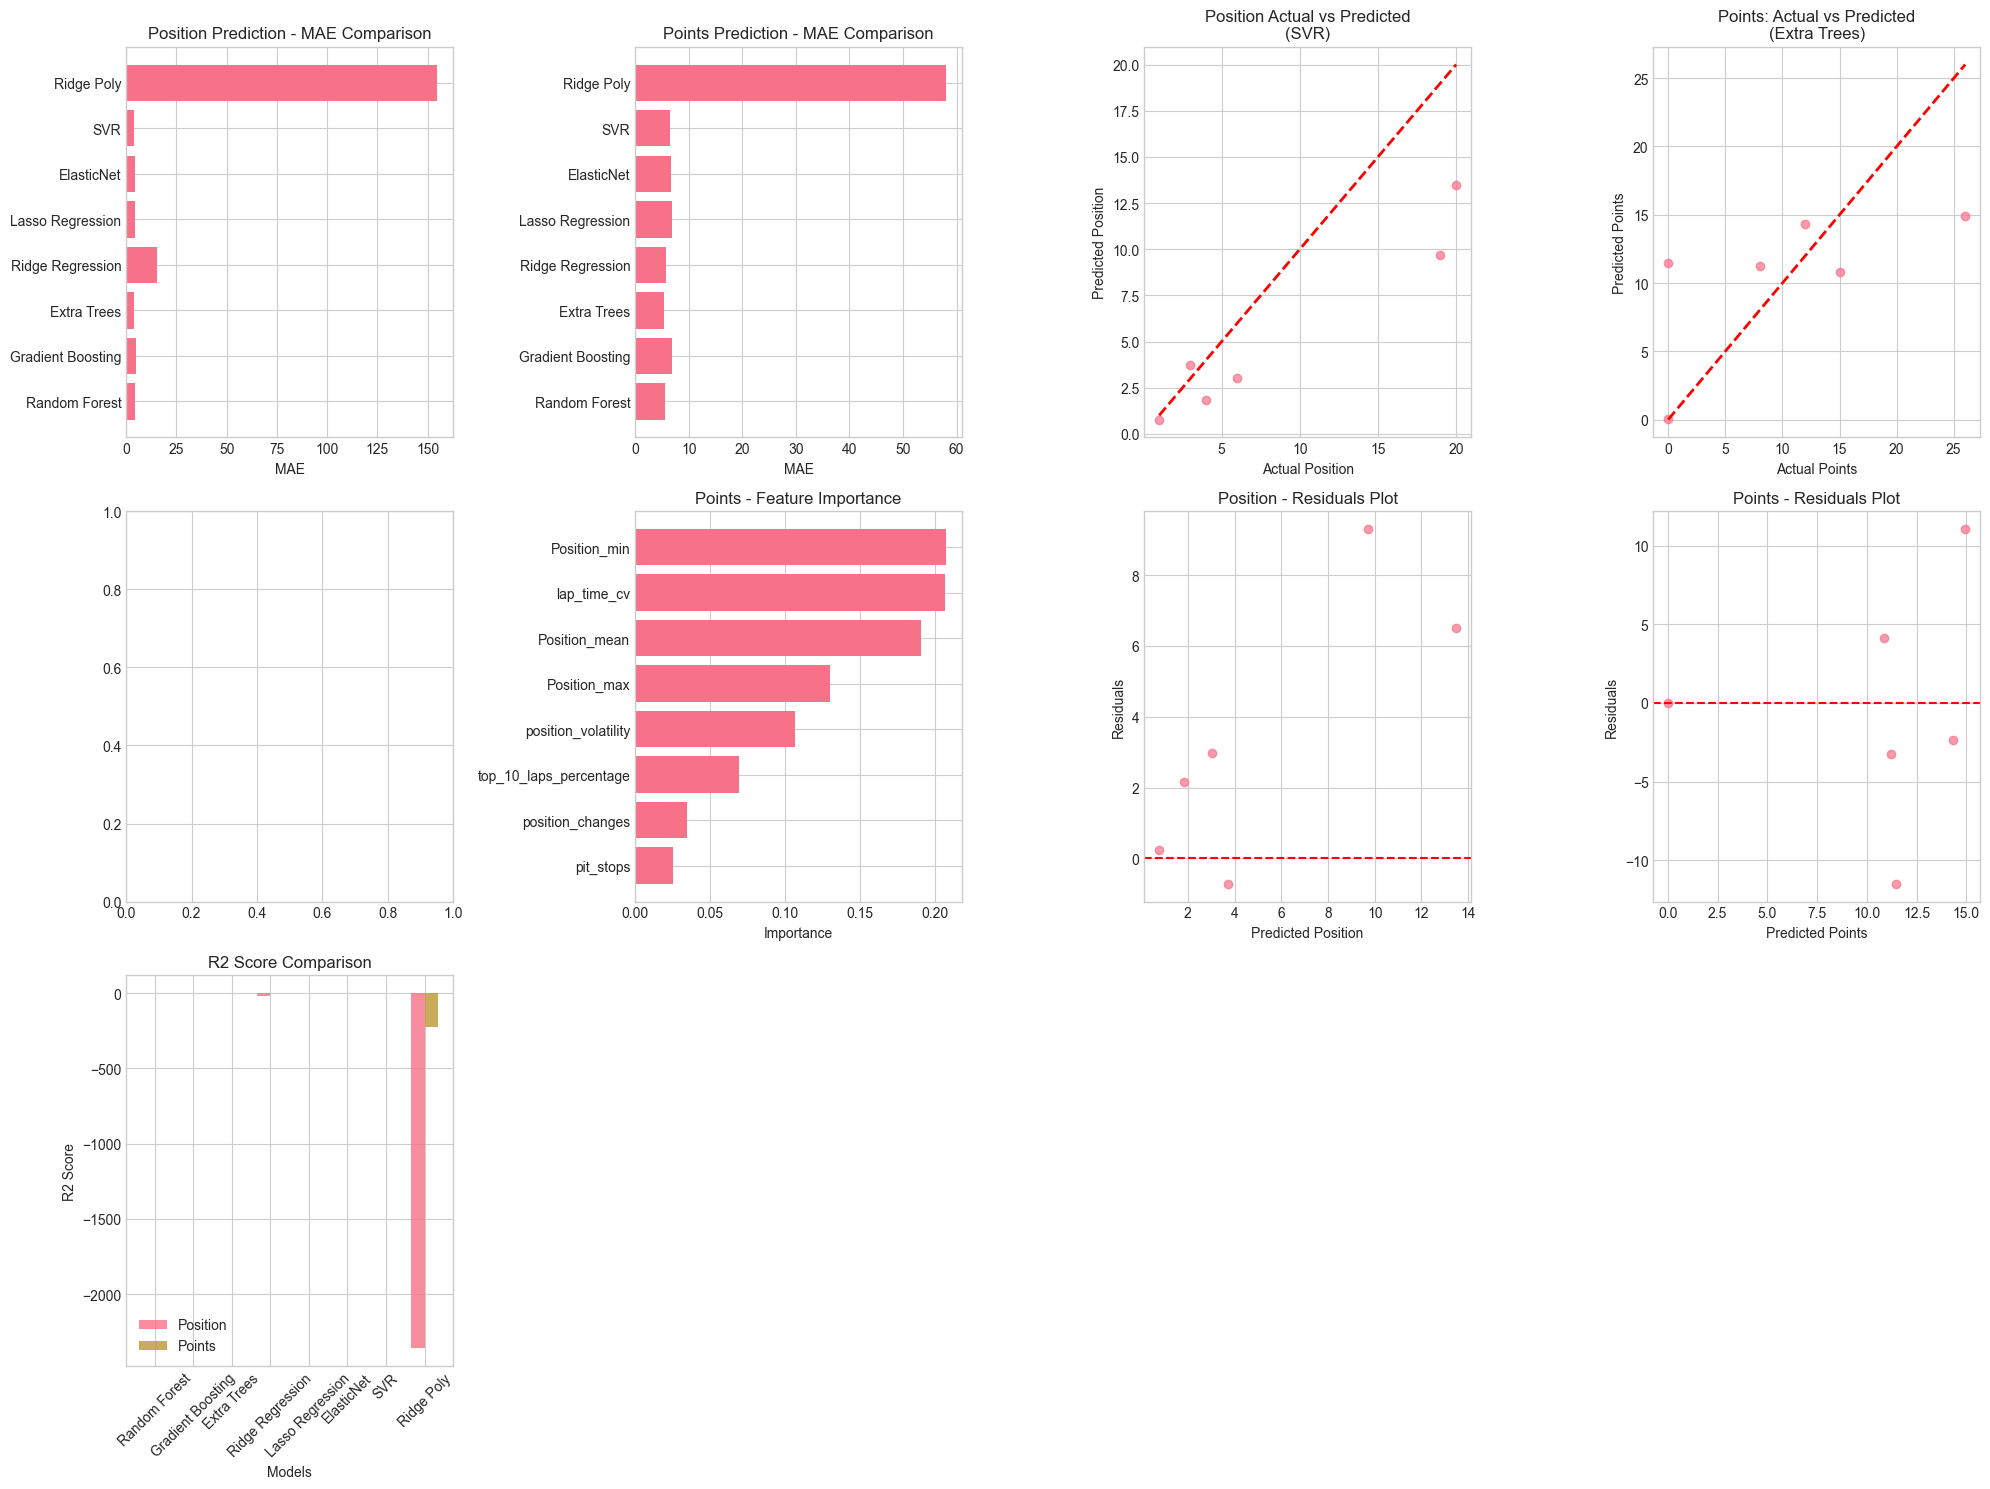

In [43]:
if pos_results and pts_results:
    visualize_results(pos_results, pts_results, pos_best_model, pts_best_model, 
                      X_test_pos, y_test_pos, X_test_pts, y_test_pts)

In [44]:
def create_results_summary(pos_results, pts_results):
    """Create a comprehensive summary of all results"""
    summary_data = []
    
    # Position results
    if pos_results:
        for name, metrics in pos_results.items():
            summary_data.append({
                'Task': 'Position',
                'Model': name,
                'CV_MAE': metrics['CV_MAE'],
                'Test_MAE': metrics['Test_MAE'],
                'Test_RMSE': metrics['Test_RMSE'],
                'Test_R2': metrics['Test_R2']
            })
            
    # Points results
    if pts_results:
        for name, metrics in pts_results.items():
            summary_data.append({
                'Task': 'Points',
                'Model': name,
                'CV_MAE': metrics['CV_MAE'],
                'Test_MAE': metrics['Test_MAE'],
                'Test_RMSE': metrics['Test_RMSE'],
                'Test_R2': metrics['Test_R2']
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df



In [45]:
if pos_results and pts_results:
    results_summary = create_results_summary(pos_results, pts_results)
    print("\n🏆 COMPREHENSIVE RESULTS SUMMARY:")
    print("="*80)
    print(results_summary.round(3).to_string(index=False))
    
    # Best models summary
    print(f"\n🥇 BEST MODELS:")
    print(f"Position Prediction: {pos_best_name}")
    print(f"Points Prediction: {pts_best_name}")


🏆 COMPREHENSIVE RESULTS SUMMARY:
    Task             Model  CV_MAE  Test_MAE  Test_RMSE   Test_R2
Position     Random Forest   2.065     4.517      5.840     0.423
Position Gradient Boosting   1.812     4.900      7.298     0.099
Position       Extra Trees   1.880     3.748      4.717     0.624
Position  Ridge Regression   1.826    15.457     32.479   -16.838
Position  Lasso Regression   1.721     4.571      5.728     0.445
Position        ElasticNet   1.722     4.385      5.353     0.515
Position               SVR   1.449     3.651      4.886     0.596
Position        Ridge Poly   3.069   154.753    373.686 -2360.238
  Points     Random Forest   2.233     5.523      7.160     0.371
  Points Gradient Boosting   1.934     6.794      8.279     0.159
  Points       Extra Trees   2.065     5.378      6.921     0.412
  Points  Ridge Regression   2.835     5.723      7.319     0.343
  Points  Lasso Regression   2.748     6.948      9.480    -0.103
  Points        ElasticNet   2.725     6.6

In [50]:
def save_models(pos_best_model, pts_best_model, pos_best_name, pts_best_name):
    """Save the best models with their complete pipelines"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # Save position model
    pos_filename = f"../models/f1_position_model_{pos_best_name.lower()}.pkl"
    joblib.dump(pos_best_model, pos_filename)
    print(f"Position model saved: {pos_filename}")
    
    pts_filename = f"../models/f1_points_model_{pts_best_name.lower()}.pkl"
    joblib.dump(pts_best_model, pts_filename)
    print(f"Points model saved: {pts_filename}")
    
    # Save model metadata
    metadata = {
        'position_model': {
            'filename': pos_filename,
            'model_name': pos_best_name,
            'pipeline_steps': list(pos_best_model.named_steps.keys()),
            'features_used': list(X.columns),
            'performance': pos_results[pos_best_name] if 'pos_results' in globals() else None 
        },
        'points_model': {
            'filename': pts_filename,
            'model_name': pts_best_name,
            'pipeline_steps': list(pts_best_model.named_steps.keys()),
            'features_used': list(X.columns),
            'performance': pts_results[pts_best_name] if 'pts_results' in globals() else None
        },
        'saved_at': timestamp,
        'data_shape': X.shape
    }
    
    import json 
    metadata_filename = "../models/f1_models_metadata.json"
    with open(metadata_filename, 'w') as f: 
        json.dump(metadata, f, indent=2, default=str)
    print(f"Metadata saved: {metadata_filename}")
    
    return pos_filename, pts_filename, metadata_filename


In [51]:
if 'pos_best_model' in globals() and 'pts_best_model' in globals():
    pos_file, pts_file, meta_file = save_models(pos_best_model, pts_best_model,
                                                pos_best_name, pts_best_name)

Position model saved: ../models/f1_position_model_svr.pkl
Points model saved: ../models/f1_points_model_extra trees.pkl
Metadata saved: ../models/f1_models_metadata.json


In [56]:
def load_models(pos_filename, pts_filename):
    """
    Load the saved models with their complete pipelines
    """
    try:
        # Load Position model
        pos_model = joblib.load(pos_filename)
        print(f"✅ Position model loaded from: {pos_filename}")
        
        # Load Points model
        pts_model = joblib.load(pts_filename)
        print(f"✅ Points model loaded from: {pts_filename}")
        
        # Inspect pipeline components
        print(f"\n📋 Position Model Pipeline:")
        for step_name, step in pos_model.named_steps.items():
            print(f"  - {step_name}: {type(step).__name__}")
            
        print(f"\n📋 Points Model Pipeline:")
        for step_name, step in pts_model.named_steps.items():
            print(f"  - {step_name}: {type(step).__name__}")
            
        return pos_model, pts_model
        
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        return None, None

# Contoh load model (ganti dengan filename yang sesuai)
loaded_pos_model, loaded_pts_model = load_models(pos_file, pts_file)

✅ Position model loaded from: ../models/f1_position_model_svr.pkl
✅ Points model loaded from: ../models/f1_points_model_extra trees.pkl

📋 Position Model Pipeline:
  - preprocessor: Pipeline
  - regressor: SVR

📋 Points Model Pipeline:
  - preprocessor: Pipeline
  - regressor: ExtraTreesRegressor


In [57]:
def test_loaded_models(pos_model, pts_model, X_test_sample):
    """
    Test the loaded models to ensure they work correctly
    """
    print("🧪 Testing loaded models...")
    
    try:
        # Test Position model
        pos_predictions = pos_model.predict(X_test_sample)
        print(f"✅ Position predictions: {pos_predictions}")
        
        # Test Points model
        pts_predictions = pts_model.predict(X_test_sample)
        print(f"✅ Points predictions: {pts_predictions}")
        
        # Verify pipeline components work
        print(f"\n🔍 Pipeline Components Test:")
        
        # Test preprocessing steps
        X_preprocessed_pos = pos_model.named_steps['preprocessor'].transform(X_test_sample)
        print(f"  - Position preprocessing output shape: {X_preprocessed_pos.shape}")
        
        X_preprocessed_pts = pts_model.named_steps['preprocessor'].transform(X_test_sample)
        print(f"  - Points preprocessing output shape: {X_preprocessed_pts.shape}")
        
        return True
        
    except Exception as e:
        print(f"❌ Error testing models: {e}")
        return False

# Test dengan sample data
if 'X_test_pos' in globals() and 'loaded_pos_model' in globals():
    test_success = test_loaded_models(loaded_pos_model, loaded_pts_model, X_test_pos[:3])

🧪 Testing loaded models...
✅ Position predictions: [0.77225204 9.69133559 3.01668924]
✅ Points predictions: [14.94 11.49 11.22]

🔍 Pipeline Components Test:
  - Position preprocessing output shape: (3, 6)
  - Points preprocessing output shape: (3, 12)
